In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import cuqi

In [2]:
from cuqi.testproblem import Heat1D
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import pCN, MH, CWMH
from cuqi.problem import BayesianProblem

In [3]:
N = 30    # Number of finite difference nodes            
L = 1     # Length of the domain
tau_max = 0.02  # Final time

In [4]:
n_steps = 3
n_steps_values = [0,1,2]
myExactSolution = np.zeros(N)

start_idx=0
for i in range(n_steps):
    end_idx = floor((i+1)*N/n_steps)
    myExactSolution[start_idx:end_idx] = n_steps_values[i]
    start_idx = end_idx

Text(0.5, 0, 'i')

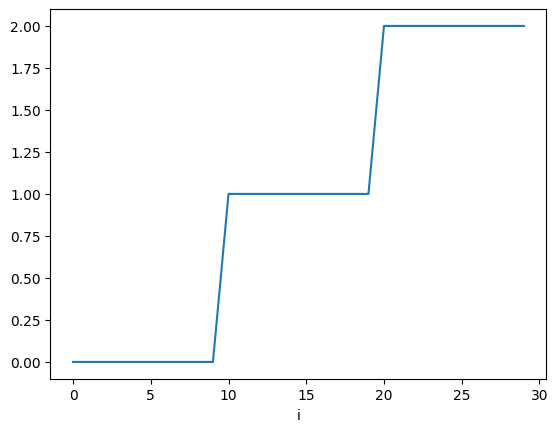

In [5]:
plt.plot(myExactSolution)
plt.xlabel("i")


In [12]:
model, data, problemInfo = Heat1D(
    dim=N,
    endpoint=L,
    max_time=tau_max,
    field_type="Step",
    field_params={"n_steps": n_steps},
).get_components()


In [13]:
model

CUQI PDEModel: StepExpansion(3,) -> Continuous1D(30,).
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.

In [9]:
mean = 0
std = 1.2
x = Gaussian(mean, std**2, geometry=model.domain_geometry)
Heat1D.model()

NameError: name 'model' is not defined

In [15]:
# Prior
mean = 0
std = 1.2
x = Gaussian(mean, std**2, geometry=model.domain_geometry)

# Data distribution
sigma_noise = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model(x), cov=sigma_noise**2, geometry=model.range_geometry)

In [16]:
print(sigma_noise)

[0.02049831 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831
 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831
 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831
 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831
 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831 0.02049831]


In [31]:
data = cuqi.array.CUQIarray(np.array(data))

In [33]:
np.save("data_heat.npy", np.array(data))

In [34]:
data = cuqi.array.CUQIarray(np.load("data_heat.npy"))

noisy data

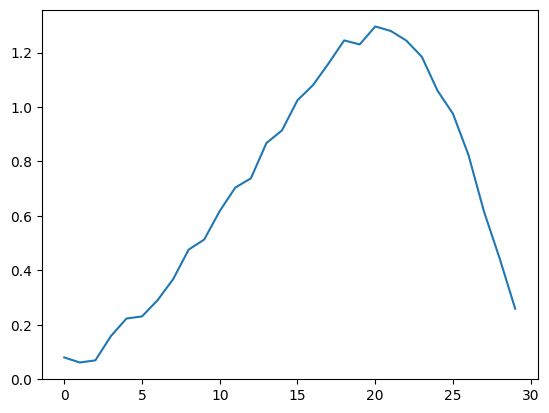

In [35]:
data.plot()

In [17]:
BP = BayesianProblem(y, x)
BP.set_data(y = data) 
posterior = BP.posterior()

In [19]:
MySampler = MH(posterior)
posterior_samples = MySampler.sample_adapt(25000)

Sample 25000 / 25000

Average acceptance rate: 0.05168 MCMC scale: 0.040206834003474676 



(3, 25000)

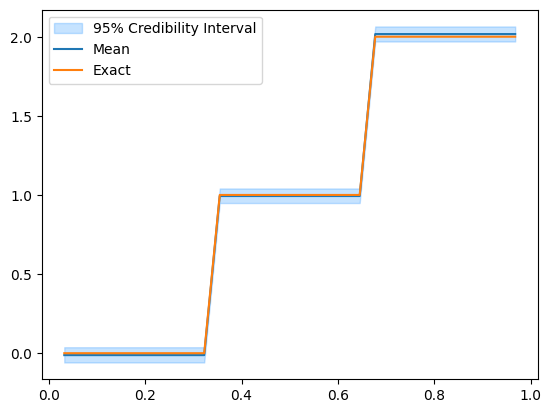

In [20]:
posterior_samples.plot_ci(95, exact=problemInfo.exactSolution)
posterior_samples.shape